## Get the data

In [56]:
# before you run this code block, download Boston AirBnB dataset to the boston/ folder:
# https://www.kaggle.com/airbnb/boston

import pandas as pd
import numpy as np


df = pd.read_csv("../boston/listings.csv")


# format price column
df['price'] = df['price'].map(lambda p: int(p[1:-3].replace(",", "")))


# format amenities strings
df['amenities'] = df['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))
amenities = np.unique(np.concatenate(df['amenities'].map(lambda amns: amns.split("|")).values))
amenities_matrix = np.array([df['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
df['amenities'] = df['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))
amenities = np.unique(np.concatenate(df['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenity_arr = np.array([df['amenities'].map(lambda amns: amn in amns) for amn in amenities]).astype(int)


# format remaining features
features = df[['host_listings_count', 'host_total_listings_count', 'accommodates', 
               'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'number_of_reviews',
               'review_scores_rating']]
features = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    features[tf_feature] = df[tf_feature].map(lambda s: 0 if s == "f" else 1)
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(df[categorical_feature])], axis=1)


# impute missing values
for col in features.columns[features.isnull().any()]:
    features[col] = features[col].fillna(features[col].median())
    
    
# remove price outliers and broken amenities columns
features = features.query('price <= 600')
features =\
    features.drop('translation missing: en.hosting_amenity_49', axis='columns')\
        .drop('translation missing: en.hosting_amenity_50', axis='columns')


# refactor into feature and target vectors 
X = features.drop('price', axis='columns')
y = features['price'].values

## Define the model

In [89]:
from keras.models import Sequential
from keras.layers import Dense

def simpleModel():    
    model = Sequential()
    model.add(Dense(3, input_dim=106))    
    model.add(Dense(9))
    model.add(Dense(1))    
    model.compile(loss='mse', optimizer='adam', metrics=["mae"])
    return model

## Define the model wrapper

In [134]:
# define the KerasClassifier wrapper wrapper
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator
class KerasBatchRegressor(KerasRegressor, BaseEstimator):
    def __init__(self, model, **kwargs):
        super().__init__(model)
        self.fit_kwargs = kwargs
        self._estimator_type = 'regressor'
        
    def fit(self, X, y, *args, **kwargs):
        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.unique(y)
        self.__history = self.model.fit(X, y, **self.fit_kwargs)


clf = KerasBatchRegressor(
    simpleModel, 
    batch_size=100, epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=0
)

## Fit the model

In [135]:
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
kf = KFold(n_splits=8)

histories = []
for train_index, test_index in tqdm_notebook(list(kf.split(X))):
    X_train, X_test = X.values[[train_index]], X.values[[test_index]]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    histories.append(clf.model.history.history)

/Users/alex/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


## The four built-in metrics in keras

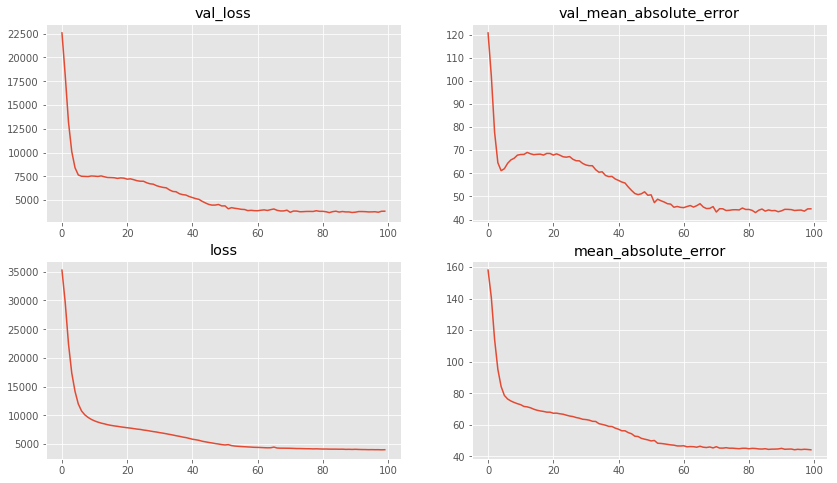

In [148]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axarr = plt.subplots(2, 2, figsize=(14, 8))

# pick a run (any of the eight, so n={0,...,7}) to see a graph
# they all have almost exactly the same shape
n = 0
for i, metric in enumerate(histories[n]):
    res = clf.model.history.history[metric]
    j, k = i // 2, i % 2
    axarr[j][k].plot(range(len(res)), res)
    axarr[j][k].set_title(metric)

## ResidualsPlot

3547/3547 [==============================] - 0s 53us/step


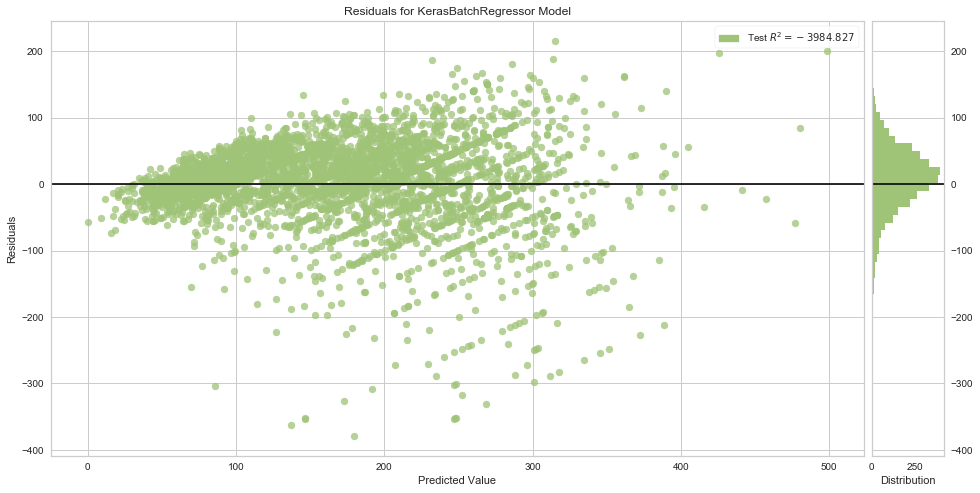

In [152]:
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 8))

visualizer = ResidualsPlot(clf, ax=ax)
visualizer.score(X, y)
visualizer.poof()

## PredictionError

In [151]:
PredictionError?

3547/3547 [==============================] - 0s 57us/step


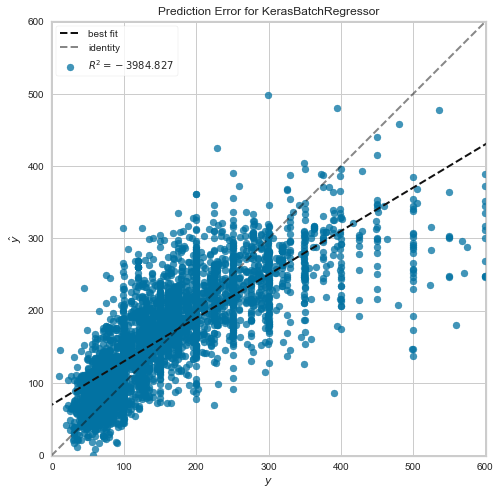

In [153]:
from yellowbrick.regressor import PredictionError

fig, ax = plt.subplots(figsize=(16, 8))

visualizer = PredictionError(clf, ax=ax)
visualizer.score(X, y)
visualizer.poof()